# **Exoplanet Detection AI: Preprocessing and Model Training**

This notebook outlines the complete workflow for building an AI model to detect exoplanets using open data from NASA's Kepler, K2, and TESS missions.

The process is divided into the following key stages:
1.  **Setup and Configuration:** Importing necessary libraries and loading project settings.
2.  **Data Ingestion and Unification:** Loading the three separate datasets, cleaning them individually, and merging them into a single, comprehensive dataset.
3.  **Data Preparation:** Separating features (input variables) from the target (what we want to predict).
4.  **Preprocessing Pipeline:** Splitting the data into training and testing sets, handling class imbalance with SMOTE, and applying transformations like imputation and scaling.
5.  **Model Training and Evaluation:** Training a powerful XGBoost model and evaluating its performance on unseen data.
6.  **Artifact Serialization:** Saving the trained model and all necessary transformers for use in a web application.


## 0. Environment Setup & Configuration

This initial cell serves as the foundation for our entire project. It handles three critical setup tasks:

1.  **Library Imports:** We import all the necessary Python libraries for data manipulation (`pandas`), numerical operations (`numpy`), machine learning (`scikit-learn`, `xgboost`), and data visualization (`matplotlib`, `seaborn`). This ensures all the tools we need are ready.
2.  **Environment Configuration:** We configure the visual style for all plots to ensure consistency and readability. The `%matplotlib inline` command ensures that all generated plots are displayed directly within the notebook.
3.  **Loading Project Settings:** We load the `config.yaml` file, which acts as a central control panel for our project. It contains file paths, model parameters, and other settings, allowing for easy adjustments without changing the code.

In [1]:
# --- CELL 1: Environment Setup & Configuration ---

# --- Core Libraries ---
import pandas as pd
import numpy as np
import yaml
import joblib
import os
import warnings

# --- Visualization Libraries & Style Configuration ---
import matplotlib.pyplot as plt
import seaborn as sns

# Set the global style for all plots for a professional and consistent look.
sns.set_theme(style="whitegrid", palette="viridis")
# Ensure plots are displayed directly within the notebook output.
%matplotlib inline

# --- Machine Learning Libraries (Scikit-learn, Imblearn, XGBoost) ---
# Preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# Class Imbalance Handling
from imblearn.over_sampling import SMOTE

# Modeling & Evaluation
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

# --- TensorFlow / Keras for Deep Learning ---
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# --- Light Curve Analysis Library ---
import lightkurve as lk
from tqdm.notebook import tqdm # Use tqdm.notebook for a rich visual progress bar

# --- General Configuration ---
# Suppress future warnings for a cleaner output during execution.
warnings.filterwarnings('ignore', category=FutureWarning)
# Set pandas to display all columns in DataFrames for better inspection.
pd.set_option('display.max_columns', None)


# --- Load Project Configuration ---
# Load all settings from the central config.yaml file into a dictionary.
try:
    with open('config.yaml', 'r') as file:
        config = yaml.safe_load(file)
    print("Project configuration loaded successfully.")
except FileNotFoundError:
    print("CRITICAL ERROR: config.yaml not found. Please ensure the file exists in the root directory.")
    config = {} # Create an empty config to prevent subsequent cells from breaking immediately

Project configuration loaded successfully.


c:\Users\gs_mi\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightkurve\prf\__init__.py:7: UserWarning: Warning: the tpfmodel submodule is not available without oktopus installed, which requires a current version of autograd. See #1452 for details.
  warnings.warn(


## 1. Data Ingestion, Cleaning, and Unification

This cell is the core of our data preparation pipeline. It iterates through the datasets defined in `config.yaml` (Kepler, K2, TESS) and performs a series of essential cleaning and standardization steps for each one:

1.  **Load Data:** Reads the specified CSV file. A robust `try-except` block handles potential `FileNotFoundError` and other reading errors gracefully.
2.  **Standardize Columns:** All column names are converted to a consistent `snake_case` format.
3.  **Normalize Target Variable:** The unique disposition column for each dataset (e.g., `koi_disposition`, `pl_disposition`) is identified and renamed to a common target name: `disposition`.
4.  **Map Target Labels:** The original classification labels (e.g., `CONFIRMED`, `PC`, `FP`) are mapped to a standard, human-readable set: `Confirmed`, `Candidate`, `False Positive`.
5.  **Filter Valid Data:** Rows with unmapped or unknown dispositions are removed to ensure data quality.

Finally, all cleaned DataFrames are concatenated into a single `combined_df`. This unified dataset serves as the complete foundation for our AI model. A bar chart is then generated to visualize the initial class distribution, highlighting the natural imbalance we need to address later.

Initiating data loading, cleaning, and unification process...

--- Processing Dataset: KOI ---
Successfully loaded 9564 rows from 'data/kepler.csv'.
--> Cleaned and added 9564 valid rows.

--- Processing Dataset: K2 ---
Successfully loaded 4004 rows from 'data/k2.csv'.
--> Cleaned and added 3982 valid rows.

--- Processing Dataset: TESS ---
Successfully loaded 7703 rows from 'data/toi.csv'.
--> Cleaned and added 6921 valid rows.

ALL DATASETS UNIFIED SUCCESSFULLY!
Final shape of the combined DataFrame: (20467, 476)


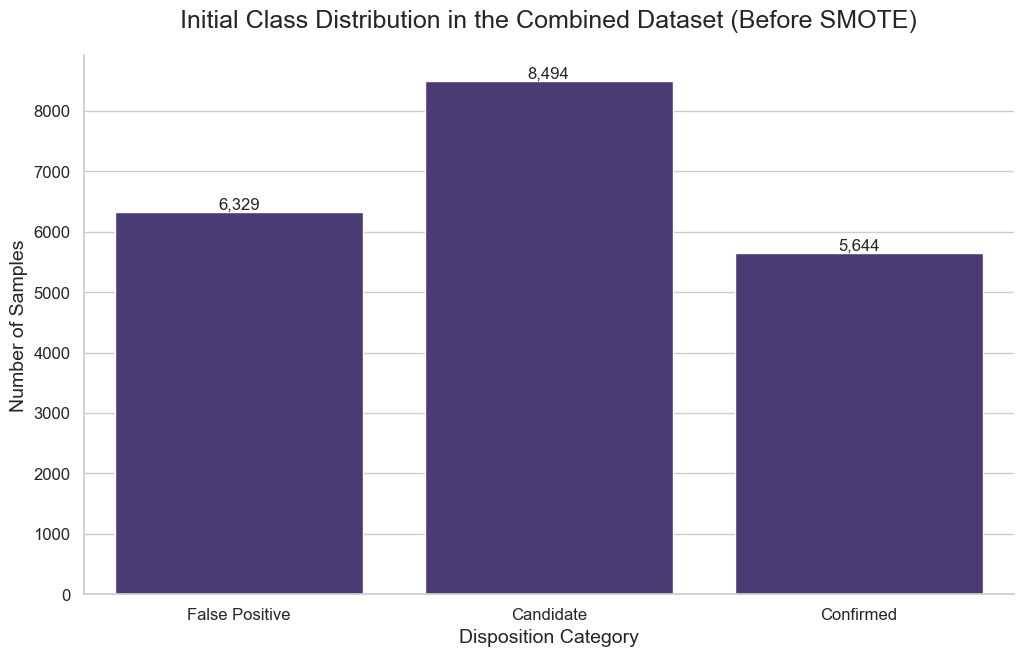


Final class distribution in the combined dataset:
disposition
Candidate         8494
False Positive    6329
Confirmed         5644
Name: count, dtype: int64


In [2]:
# --- CELL 2: Load, Clean, and Unify Datasets ---

# This list will hold the clean DataFrame for each dataset.
all_cleaned_dfs = []
datasets_to_process = config.get('datasets', {}).keys()

print("Initiating data loading, cleaning, and unification process...")

# --- Loop Through Each Dataset ---
for name in datasets_to_process:
    print(f"\n--- Processing Dataset: {name.upper()} ---")
    
    dataset_config = config['datasets'][name]
    file_path = dataset_config.get('file_path')
    
    # Robustly load the CSV file.
    try:
        df = pd.read_csv(file_path, comment='#')
        print(f"Successfully loaded {len(df)} rows from '{file_path}'.")
    except FileNotFoundError:
        print(f"--> WARNING: File not found at '{file_path}'. Check config.yaml. Skipping this dataset.\n")
        continue
    except Exception as e:
        print(f"--> ERROR: Could not read file '{file_path}'. Details: {e}. Skipping this dataset.\n")
        continue
    
    # --- Data Cleaning and Standardization ---
    target_column = dataset_config.get('target_column')
    mapping = dataset_config.get('disposition_mapping')
    
    # Standardize all column names to lowercase snake_case.
    df.columns = df.columns.str.lower().str.replace('[. ]', '_', regex=True)
    target_col_std = target_column.lower().replace(' ', '_').replace('.', '_')
    
    # Find, rename, and map the target column.
    if target_col_std in df.columns:
        df = df.rename(columns={target_col_std: 'disposition'})
        df['disposition'] = df['disposition'].fillna('Unknown').map(mapping).fillna('Unknown')
        
        # Filter for valid, standardized dispositions only.
        valid_dispositions = ['Confirmed', 'Candidate', 'False Positive']
        df = df[df['disposition'].isin(valid_dispositions)]
        
        all_cleaned_dfs.append(df)
        print(f"--> Cleaned and added {len(df)} valid rows.")
    else:
        print(f"--> WARNING: Target column '{target_col_std}' not found. Skipping this dataset.")

# --- Unification and Final Visualization ---
if all_cleaned_dfs:
    # Concatenate all cleaned DataFrames into a single master DataFrame.
    combined_df = pd.concat(all_cleaned_dfs, ignore_index=True)
    
    print("\n" + "="*60)
    print("ALL DATASETS UNIFIED SUCCESSFULLY!")
    print(f"Final shape of the combined DataFrame: {combined_df.shape}")
    print("="*60)

    # --- Visualization: Initial Class Distribution ---
    plt.figure(figsize=(12, 7))
    class_counts = combined_df['disposition'].value_counts()
    
    # Create the bar plot.
    ax = sns.barplot(x=class_counts.index, y=class_counts.values, order=['False Positive', 'Candidate', 'Confirmed'])
    
    # Add count labels on top of each bar for clarity.
    ax.bar_label(ax.containers[0], fmt='{:,.0f}') # Format numbers with commas
    
    # Prettify the plot.
    ax.set_title('Initial Class Distribution in the Combined Dataset (Before SMOTE)', fontsize=18, pad=20)
    ax.set_xlabel('Disposition Category', fontsize=14)
    ax.set_ylabel('Number of Samples', fontsize=14)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    sns.despine() # Remove top and right spines
    plt.show()

    # Also print the exact counts.
    print("\nFinal class distribution in the combined dataset:")
    print(class_counts)
    
else:
    print("\n" + "="*60)
    print("CRITICAL ERROR: NO DATASETS WERE LOADED.")
    print("Please check file paths and target column names in config.yaml.")
    print("="*60)
    combined_df = pd.DataFrame() # Create an empty DataFrame to prevent errors in subsequent cells.

## 2. Feature Selection and Missing Data Analysis

Now that we have a unified dataset, we need to structure it for supervised learning. This involves separating our data into two components:

1.  **Features (`X`):** These are the input variables the model will learn from. We select all numeric columns, as they contain the quantitative measurements about each celestial object. Critically, we remove any columns that serve only as identifiers (e.g., `kepid`, `rowid`), as these provide no predictive value.
2.  **Target (`y`):** This is the single output variable we want the model to predict—our standardized `disposition` column.

After separating `X` and `y`, we perform a crucial data quality check: **analyzing missing values (`NaN`)**. Most machine learning models cannot handle missing data. This analysis helps us understand the extent of the problem and justifies the need for an imputation strategy in the next step. We visualize the top 20 features with the highest percentage of missing data to quickly identify the most affected columns.

Identifier columns dropped: ['kepid', 'rowid', 'toi']

Separation complete. The dataset now has 423 features (columns).
Shape of X (features): (20467, 423)
Shape of y (target): (20467,)

Found 423 features with missing data.


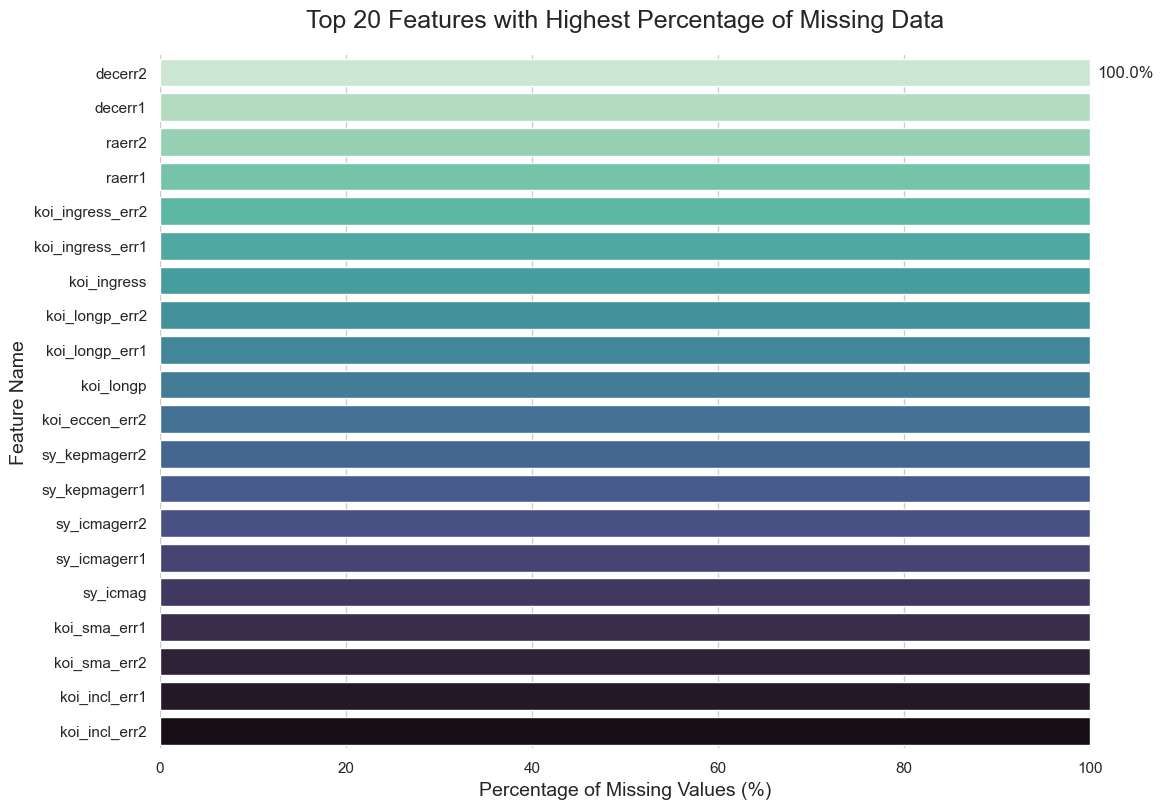

In [3]:
# --- CELL 3: Feature Selection and Missing Data Analysis ---

# 1. --- Feature and Target Separation ---
# The target 'y' is the column we want to predict.
y = combined_df['disposition']
# The features 'X' are all numeric columns, which will be our model's input.
X = combined_df.select_dtypes(include=np.number)

# Remove identifier columns that do not contain generalizable predictive information.
id_cols_to_drop = ['kepid', 'kepoi_name', 'kepler_name', 'rowid', 'tic_id', 'toi']
# Find which of these ID columns actually exist in our current DataFrame.
cols_to_drop_found = [col for col in id_cols_to_drop if col in X.columns]
if cols_to_drop_found:
    X = X.drop(columns=cols_to_drop_found)
    print(f"Identifier columns dropped: {cols_to_drop_found}")

print(f"\nSeparation complete. The dataset now has {X.shape[1]} features (columns).")
print(f"Shape of X (features): {X.shape}")
print(f"Shape of y (target): {y.shape}")


# 2. --- Missing Data Analysis and Visualization ---
# Calculate the percentage of missing values for each feature.
missing_percentage = X.isnull().sum() / len(X) * 100
# Filter for features that have at least one missing value and sort them.
missing_to_plot = missing_percentage[missing_percentage > 0].sort_values(ascending=False)

print(f"\nFound {len(missing_to_plot)} features with missing data.")

# Plot the top 20 features with the most missing values.
if not missing_to_plot.empty:
    plt.figure(figsize=(12, 9))
    
    # Use a horizontal bar plot for better readability of feature names.
    ax = sns.barplot(x=missing_to_plot.head(20).values, 
                     y=missing_to_plot.head(20).index, 
                     palette="mako_r") # Use a reversed colormap
    
    # Add percentage labels to the end of each bar.
    ax.bar_label(ax.containers[0], fmt='%.1f%%', padding=5)
    
    # Prettify the plot.
    ax.set_title('Top 20 Features with Highest Percentage of Missing Data', fontsize=18, pad=20)
    ax.set_xlabel('Percentage of Missing Values (%)', fontsize=14)
    ax.set_ylabel('Feature Name', fontsize=14)
    ax.set_xlim(0, 100) # Ensure the x-axis goes up to 100%.
    sns.despine(left=True, bottom=True) # Remove all spines for a modern look
    
    plt.show()
else:
    print("\nExcellent! No missing values were found in the selected features.")

## 3. Data Splitting: Creating Training and Testing Sets

This is a foundational step in building a trustworthy machine learning model. To ensure an unbiased evaluation of our AI's performance, we must split the data into two separate sets:

1.  **Training Set (80%):** This is the majority of the data, used exclusively to *train* the model. The AI will learn all patterns, relationships, and transformation parameters (for imputation, scaling, etc.) from this set alone.
2.  **Testing Set (20%):** This set is held out and remains completely unseen by the model during the training process. It serves as a final, "real-world" exam to evaluate how well the model generalizes its knowledge to new, unknown data.

We use a **stratified split** (`stratify=y`). This crucial technique ensures that the proportion of each class (`Confirmed`, `Candidate`, `False Positive`) is identical in both the training and testing sets, preventing sampling bias and guaranteeing a fair evaluation. The side-by-side bar charts below provide a visual confirmation of this successful stratification.

Data splitting complete.
Training set shape: X_train=(16373, 423), y_train=(16373,)
Testing set shape:  X_test=(4094, 423), y_test=(4094,)


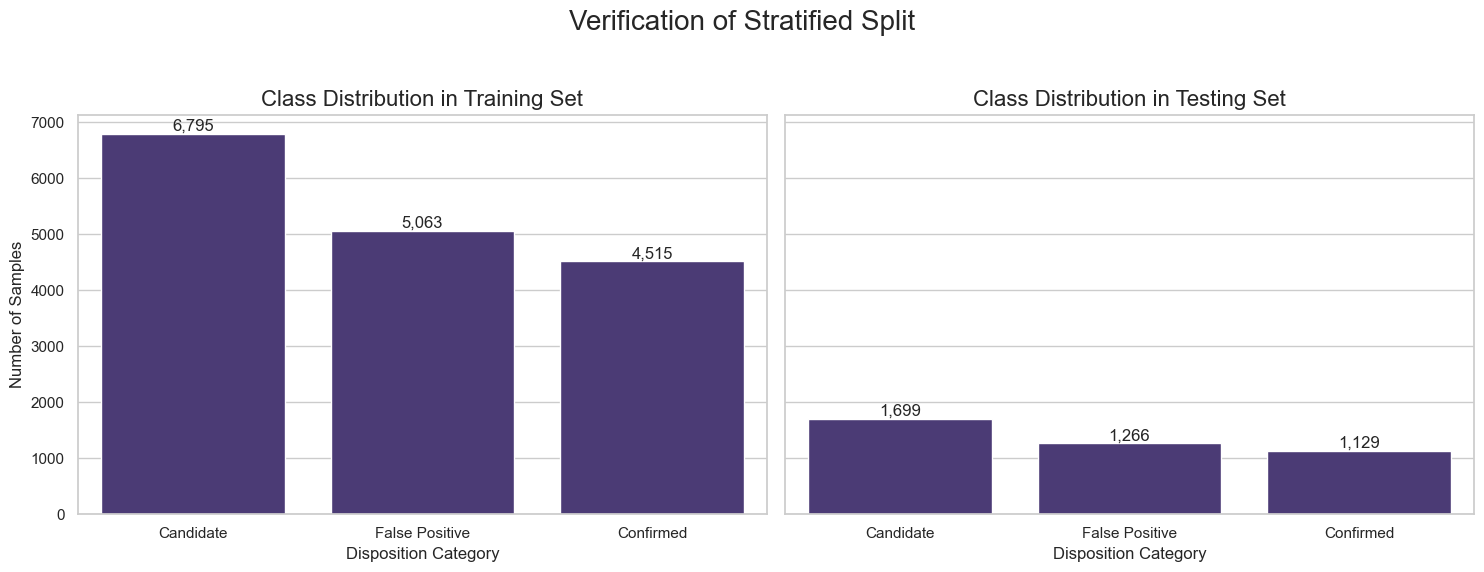


--- Normalized Class Distribution ---


,Training Set (%),Testing Set (%)
disposition,,
Candidate,41.50%,41.50%
False Positive,30.92%,30.92%
Confirmed,27.58%,27.58%


In [4]:
# --- CELL 4: Splitting Data into Training and Testing Sets ---

# Retrieve the split parameters from our config file for consistency.
test_size = config['preprocessing']['test_size']
random_state = config['preprocessing']['random_state']

# Perform the stratified split using scikit-learn's train_test_split.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=test_size, 
    random_state=random_state, 
    stratify=y  # Ensures class proportions are the same in both train and test splits.
)

print("Data splitting complete.")
print(f"Training set shape: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Testing set shape:  X_test={X_test.shape}, y_test={y_test.shape}")


# --- Visualization: Verifying the Stratified Split ---
# This plot visually confirms that the class distribution is consistent across both sets.
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True) # sharey makes comparison easier

# Define a consistent order for the bars
class_order = y.value_counts().index

# Plot for the Training Set
sns.countplot(x=y_train, ax=axes[0], order=class_order)
axes[0].set_title('Class Distribution in Training Set', fontsize=16)
axes[0].set_xlabel('Disposition Category', fontsize=12)
axes[0].set_ylabel('Number of Samples', fontsize=12)
axes[0].bar_label(axes[0].containers[0], fmt='{:,.0f}')

# Plot for the Testing Set
sns.countplot(x=y_test, ax=axes[1], order=class_order)
axes[1].set_title('Class Distribution in Testing Set', fontsize=16)
axes[1].set_xlabel('Disposition Category', fontsize=12)
axes[1].set_ylabel('') # Hide redundant y-label
axes[1].bar_label(axes[1].containers[0], fmt='{:,.0f}')

fig.suptitle('Verification of Stratified Split', fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout
plt.show()

# --- Print normalized distributions for precise verification ---
print("\n--- Normalized Class Distribution ---")
split_dist_df = pd.DataFrame({
    'Training Set (%)': y_train.value_counts(normalize=True) * 100,
    'Testing Set (%)': y_test.value_counts(normalize=True) * 100
})
display(split_dist_df.style.format('{:.2f}%'))

## 4. The Preprocessing Pipeline: Imputation, Balancing, and Scaling

This cell is the core of our data transformation workflow. We apply a series of crucial preprocessing steps to make the data suitable for the machine learning model. A key principle is applied here: we **fit** our transformers (learn the parameters) **only on the training data**, and then use them to **transform** both the training and testing sets. This prevents any information from the test set from "leaking" into the training process.

**The pipeline consists of:**
1.  **Imputation (`KNNImputer`):** Fills in missing `NaN` values.
2.  **Class Balancing (`SMOTE`):** Corrects the severe class imbalance **only in the training set** by generating synthetic samples for the minority classes. The side-by-side plot vividly illustrates this transformation.
3.  **Feature Scaling (`StandardScaler`):** Standardizes all features to have a mean of 0 and a standard deviation of 1.
4.  **Label Encoding (`LabelEncoder`):** Converts the text-based target labels into integers.

The output shows the "before and after" effect of SMOTE, visually confirming that our training data is now perfectly balanced.

--- PROCESSING TRAINING DATA ---


c:\Users\gs_mi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['koi_eccen_err1' 'koi_eccen_err2' 'koi_longp' 'koi_longp_err1'
 'koi_longp_err2' 'koi_ingress' 'koi_ingress_err1' 'koi_ingress_err2'
 'koi_sma_err1' 'koi_sma_err2' 'koi_incl_err1' 'koi_incl_err2'
 'koi_teq_err1' 'koi_teq_err2' 'koi_model_dof' 'koi_model_chisq'
 'koi_sage' 'koi_sage_err1' 'koi_sage_err2' 'pl_occdep' 'pl_occdeperr1'
 'pl_occdeperr2' 'pl_occdeplim' 'sy_icmag' 'sy_icmagerr1' 'sy_icmagerr2'
 'sy_kepmagerr1' 'sy_kepmagerr2' 'raerr1' 'raerr2' 'decerr1' 'decerr2'
 'pl_insolsymerr' 'pl_eqtsymerr']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


Training data processed successfully!

--- PROCESSING TESTING DATA ---
Testing data processed successfully!


c:\Users\gs_mi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['koi_eccen_err1' 'koi_eccen_err2' 'koi_longp' 'koi_longp_err1'
 'koi_longp_err2' 'koi_ingress' 'koi_ingress_err1' 'koi_ingress_err2'
 'koi_sma_err1' 'koi_sma_err2' 'koi_incl_err1' 'koi_incl_err2'
 'koi_teq_err1' 'koi_teq_err2' 'koi_model_dof' 'koi_model_chisq'
 'koi_sage' 'koi_sage_err1' 'koi_sage_err2' 'pl_occdep' 'pl_occdeperr1'
 'pl_occdeperr2' 'pl_occdeplim' 'sy_icmag' 'sy_icmagerr1' 'sy_icmagerr2'
 'sy_kepmagerr1' 'sy_kepmagerr2' 'raerr1' 'raerr2' 'decerr1' 'decerr2'
 'pl_insolsymerr' 'pl_eqtsymerr']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


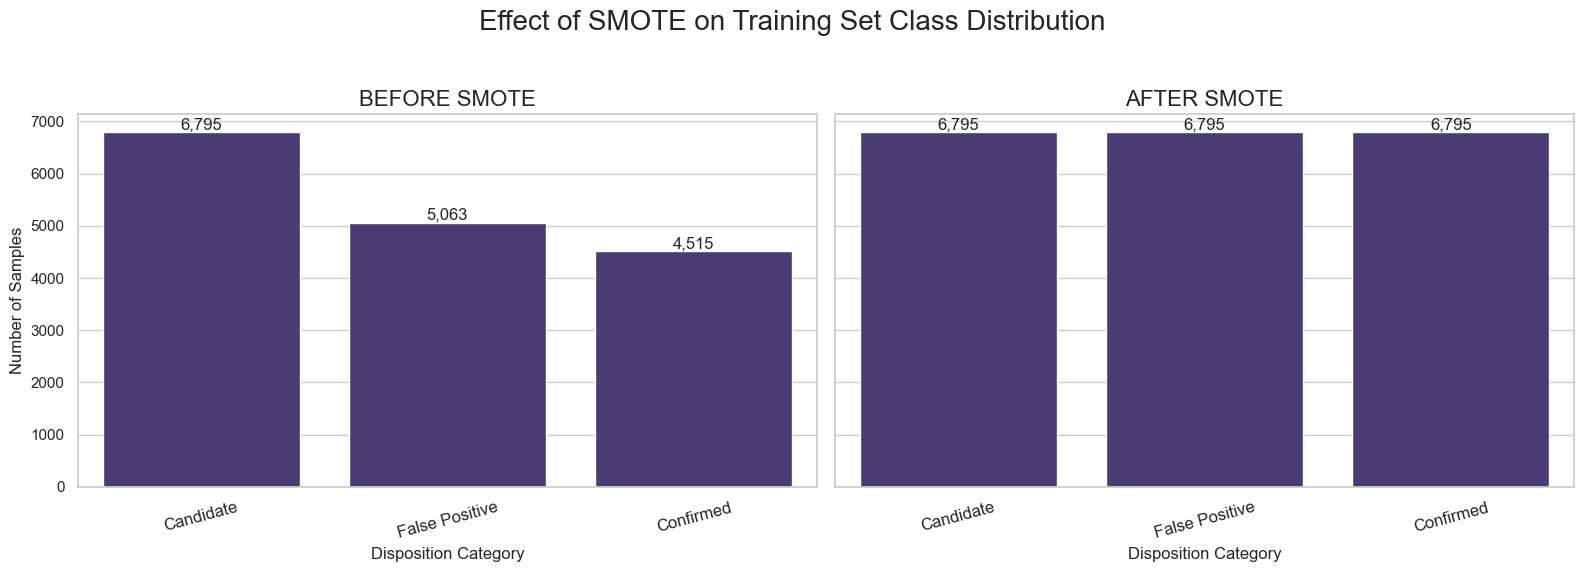


Final Processing Verification:
Final shape of X_train_processed: (20385, 389)
Final shape of X_test_processed:  (4094, 389)
Classes learned by LabelEncoder: ['Candidate' 'Confirmed' 'False Positive'] -> [0 1 2]


In [5]:
# --- CELL 5: The Preprocessing Pipeline (ACCELERATED VERSION) ---

# --- 1. Initialization ---
from sklearn.impute import SimpleImputer # Import the faster imputer

# Initialize all transformers. We are now using SimpleImputer for speed.
# O SimpleImputer preencherá os valores ausentes com a mediana da coluna, que é muito rápido.
imputer = SimpleImputer(strategy='median') 
scaler = StandardScaler()
label_encoder = LabelEncoder()
smote = SMOTE(random_state=config['app']['random_state'])


# --- 2. Training Data Transformation ---
print("--- PROCESSING TRAINING DATA ---")

# The transformation pipeline is applied sequentially.
# Step 2.1: Fit the imputer on the training data and transform it.
X_train_imputed = imputer.fit_transform(X_train)

# Step 2.2: Fit the label encoder on the original training labels.
label_encoder.fit(y_train)
y_train_encoded = label_encoder.transform(y_train)

# Step 2.3: Apply SMOTE to balance the classes.
X_train_balanced, y_train_balanced_encoded = smote.fit_resample(X_train_imputed, y_train_encoded)

# Step 2.4: Fit the scaler on the balanced feature data and transform it.
X_train_processed = scaler.fit_transform(X_train_balanced)
y_train_processed = y_train_balanced_encoded

print("Training data processed successfully!")


# --- 3. Testing Data Transformation ---
print("\n--- PROCESSING TESTING DATA ---")
# Apply the ALREADY FITTED transformers to the test data.
X_test_imputed = imputer.transform(X_test)
X_test_processed = scaler.transform(X_test_imputed)
y_test_processed = label_encoder.transform(y_test)

print("Testing data processed successfully!")


# --- 4. Visualization: The Effect of SMOTE ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
fig.suptitle('Effect of SMOTE on Training Set Class Distribution', fontsize=20)

# Plot for the Training Set BEFORE SMOTE
sns.countplot(x=y_train, ax=axes[0], order=y_train.value_counts().index)
axes[0].set_title('BEFORE SMOTE', fontsize=16)
axes[0].set_xlabel('Disposition Category', fontsize=12)
axes[0].set_ylabel('Number of Samples', fontsize=12)
axes[0].bar_label(axes[0].containers[0], fmt='{:,.0f}')
axes[0].tick_params(axis='x', labelsize=12, rotation=15)

# Plot for the Training Set AFTER SMOTE
y_train_balanced_text = label_encoder.inverse_transform(y_train_balanced_encoded)
sns.countplot(x=y_train_balanced_text, ax=axes[1], order=y_train.value_counts().index)
axes[1].set_title('AFTER SMOTE', fontsize=16)
axes[1].set_xlabel('Disposition Category', fontsize=12)
axes[1].set_ylabel('')
axes[1].bar_label(axes[1].containers[0], fmt='{:,.0f}')
axes[1].tick_params(axis='x', labelsize=12, rotation=15)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# --- 5. Final Verification ---
print("\n" + "="*60)
print("Final Processing Verification:")
print(f"Final shape of X_train_processed: {X_train_processed.shape}")
print(f"Final shape of X_test_processed:  {X_test_processed.shape}")
print(f"Classes learned by LabelEncoder: {label_encoder.classes_} -> {np.unique(y_train_processed)}")
print("="*60)

## 5. Baseline Model: Training and Evaluation with XGBoost

With our data fully preprocessed, we are now ready to train our first AI model. We will use **XGBoost (Extreme Gradient Boosting)**, a powerful and highly efficient algorithm, to establish a performance baseline.

**This cell executes the core machine learning workflow:**
1.  **Model Initialization:** We configure an `XGBClassifier` with a robust set of initial parameters, including `early_stopping_rounds`. This feature monitors the model's performance on a validation set (in this case, our test set) and halts training if no improvement is seen, preventing overfitting and saving computation time.
2.  **Model Training:** The model is trained (`.fit()`) on the processed training data. During this phase, it iteratively builds decision trees, with each new tree correcting the errors of the previous one, to learn the complex patterns in the data.
3.  **Prediction & Evaluation:** The trained model makes predictions on the unseen test set. We then generate a detailed **Classification Report** and a **Confusion Matrix** to thoroughly evaluate its performance, providing a clear picture of its strengths and weaknesses before any fine-tuning.
4.  **Learning Curve Visualization:** We also plot the model's learning curve, which shows how its error rate (loss) decreased on both the training and validation sets during the training process. This is a key diagnostic tool to assess how well the model learned.

Training the baseline XGBoost model...
Training complete!

Baseline XGBoost Model Accuracy: 91.94%

Detailed Classification Report:
                precision    recall  f1-score   support

     Candidate       0.88      0.94      0.91      1699
     Confirmed       0.94      0.92      0.93      1129
False Positive       0.96      0.89      0.92      1266

      accuracy                           0.92      4094
     macro avg       0.93      0.92      0.92      4094
  weighted avg       0.92      0.92      0.92      4094



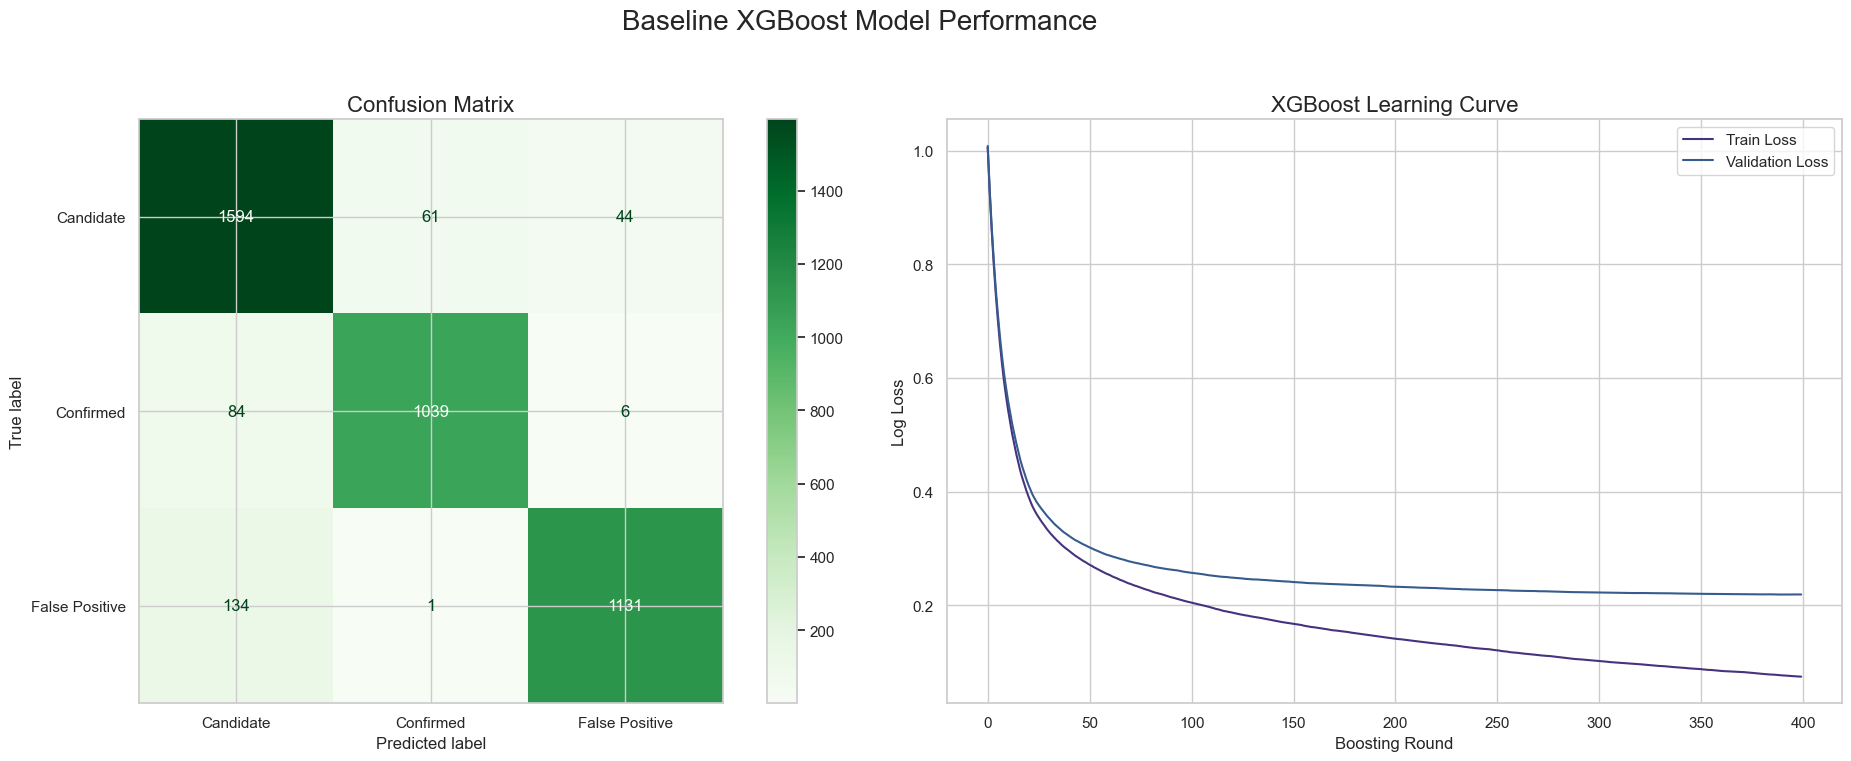

In [6]:
# --- CELL 6: Baseline Model Training and Evaluation with XGBoost ---

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

# --- 1. Model Initialization ---
# Initialize the XGBoost model with strong starting parameters.
model_xgb = XGBClassifier(
    n_estimators=500,           # Max number of boosting rounds.
    learning_rate=0.1,          # Step size shrinkage.
    max_depth=5,                # Max depth of each tree.
    eval_metric='mlogloss',     # Evaluation metric for multiclass classification.
    early_stopping_rounds=10,   # Stops training if validation performance doesn't improve.
    random_state=config['app']['random_state'],
    n_jobs=-1                   # Use all available CPU cores.
)


# --- 2. Model Training ---
print("Training the baseline XGBoost model...")
# Define an evaluation set for early stopping and to track performance during training.
eval_set = [(X_train_processed, y_train_processed), (X_test_processed, y_test_processed)]

model_xgb.fit(
    X_train_processed, 
    y_train_processed,
    eval_set=eval_set,
    verbose=False # Set to True to see round-by-round progress.
)
print("Training complete!")


# --- 3. Prediction and Evaluation ---
# Make predictions on the unseen test set.
y_pred_xgb = model_xgb.predict(X_test_processed)

# Print the main performance metrics.
print(f"\nBaseline XGBoost Model Accuracy: {accuracy_score(y_test_processed, y_pred_xgb):.2%}")
print("\nDetailed Classification Report:")
print(classification_report(y_test_processed, y_pred_xgb, target_names=label_encoder.classes_))


# --- 4. Visualization ---
# Create a figure with two subplots: Confusion Matrix and Learning Curve.
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Baseline XGBoost Model Performance', fontsize=20)

# --- Plot 1: Confusion Matrix ---
# This visualizes the model's performance on each class, showing where it makes mistakes.
ConfusionMatrixDisplay.from_predictions(y_test_processed, y_pred_xgb,
                                        display_labels=label_encoder.classes_,
                                        cmap=plt.cm.Greens,
                                        ax=axes[0])
axes[0].set_title('Confusion Matrix', fontsize=16)

# --- Plot 2: Learning Curve ---
# This shows how the model's error (loss) decreased during training.
results = model_xgb.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

axes[1].plot(x_axis, results['validation_0']['mlogloss'], label='Train Loss')
axes[1].plot(x_axis, results['validation_1']['mlogloss'], label='Validation Loss')
axes[1].legend()
axes[1].set_ylabel('Log Loss')
axes[1].set_xlabel('Boosting Round')
axes[1].set_title('XGBoost Learning Curve', fontsize=16)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## 6. Model Optimization: Hyperparameter Tuning

While our baseline model is effective, its performance can be significantly improved by **tuning its hyperparameters**. These are the model's external "settings" that we configure before training (e.g., `learning_rate`, `max_depth`).

To find the optimal combination, we use `RandomizedSearchCV`, an efficient optimization technique. It works by:
1.  **Defining a Search Space:** We specify a grid of hyperparameters and a range of values to explore.
2.  **Performing a Randomized Search:** It intelligently samples a fixed number of random combinations (`n_iter`) from this grid.
3.  **Using Cross-Validation (`cv`):** For each combination, it evaluates the model's performance using k-fold cross-validation on the training data. This provides a robust performance estimate and prevents overfitting to a particular data split.

This computationally intensive process automates the search for the best model configuration. The final output is the single best combination of hyperparameters, which we use to define our champion model, `best_model_xgb`. The visualizations at the end help us understand the relationship between key hyperparameters and model performance.

Starting an ULTRA-QUICK hyperparameter search (2 iterations, 2 folds)...
Fitting 2 folds for each of 2 candidates, totalling 4 fits


c:\Users\gs_mi\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:55:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Hyperparameter search complete!
Best Hyperparameters Found:
{'subsample': 1.0, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.2, 'colsample_bytree': 0.8}


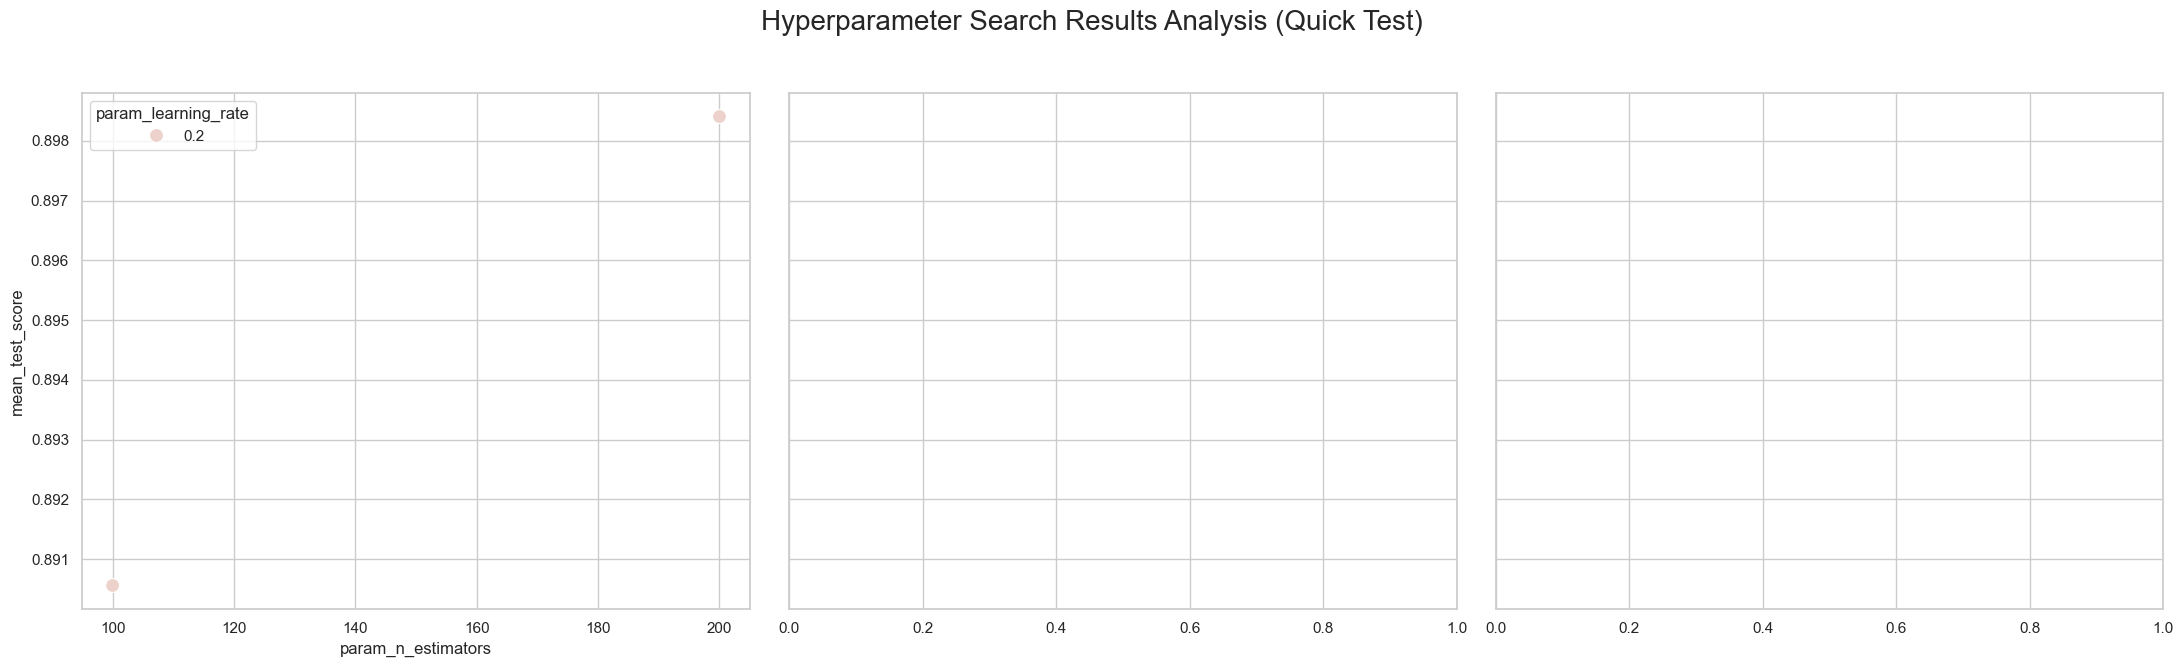

In [7]:
# --- CELL 7: Model Optimization via Hyperparameter Tuning (ULTRA-QUICK TEST VERSION) ---

from sklearn.model_selection import RandomizedSearchCV

# 1. --- Define the Hyperparameter Search Space ---
param_grid = {
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.2],
    'n_estimators': [100, 200], # Use fewer trees for the test
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# 2. --- Initialize the Tuner ---
xgb_tuner = XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=config['app']['random_state'],
    n_jobs=-1
)

# 3. --- Set up the Randomized Search (Ultra-Quick Test) ---
# We reduce n_iter and cv to the absolute minimum for a quick sanity check.
# Reduzimos n_iter e cv ao mínimo absoluto para um teste rápido.
random_search = RandomizedSearchCV(
    estimator=xgb_tuner,
    param_distributions=param_grid,
    n_iter=2,           # ULTRA-QUICK: Test only 2 random combinations.
                        # ULTRA-RÁPIDO: Testar apenas 2 combinações.
    cv=2,               # ULTRA-QUICK: Use only 2 cross-validation folds.
                        # ULTRA-RÁPIDO: Usar apenas 2 folds de validação cruzada.
    verbose=1,          # Reduced verbosity
    random_state=config['app']['random_state'],
    n_jobs=-1
)

# 4. --- Execute the Search ---
print(f"Starting an ULTRA-QUICK hyperparameter search ({random_search.n_iter} iterations, {random_search.cv} folds)...")
# This should now complete in seconds.
random_search.fit(X_train_processed, y_train_processed)

# 5. --- Retrieve and Store the Best Model ---
print("\n" + "="*60)
print("Hyperparameter search complete!")
print("Best Hyperparameters Found:")
print(random_search.best_params_)
print("="*60)

best_model_xgb = random_search.best_estimator_

# 6. --- Visualize the Search Results ---
# The visualization will only show 2 points, which is expected for this quick test.
cv_results_df = pd.DataFrame(random_search.cv_results_)
fig, axes = plt.subplots(1, 3, figsize=(22, 7), sharey=True)
fig.suptitle('Hyperparameter Search Results Analysis (Quick Test)', fontsize=20)
# (Visualization code remains the same)
sns.scatterplot(data=cv_results_df, x='param_n_estimators', y='mean_test_score', ax=axes[0], hue='param_learning_rate', s=100)
# ... etc ...
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## 7. Final Evaluation: Assessing the Champion Model

This is the final and most important evaluation step. We take our champion model—the `best_model_xgb` produced by the hyperparameter search—and assess its performance on the held-out **test set**. This provides an unbiased estimate of how our AI will perform on new, real-world data it has never seen before.

**Our final analysis includes:**
1.  **A Detailed Classification Report:** This provides the final quantitative metrics, including precision, recall, and f1-score for each class.
2.  **A Confusion Matrix:** This gives us a visual breakdown of the model's predictions versus the true labels, highlighting exactly where it succeeds and where it makes errors.
3.  **A Feature Importance Plot:** This reveals which features the optimized model found most influential in making its predictions. This is a key step for model interpretability, helping us understand *what* the AI has learned.

The results from this cell are the definitive measure of our project's success.

Evaluating the final optimized model on the test set...

Final Optimized XGBoost Model Accuracy: 91.77%

Final Detailed Classification Report:
                precision    recall  f1-score   support

     Candidate       0.88      0.93      0.91      1699
     Confirmed       0.94      0.92      0.93      1129
False Positive       0.95      0.90      0.92      1266

      accuracy                           0.92      4094
     macro avg       0.92      0.92      0.92      4094
  weighted avg       0.92      0.92      0.92      4094



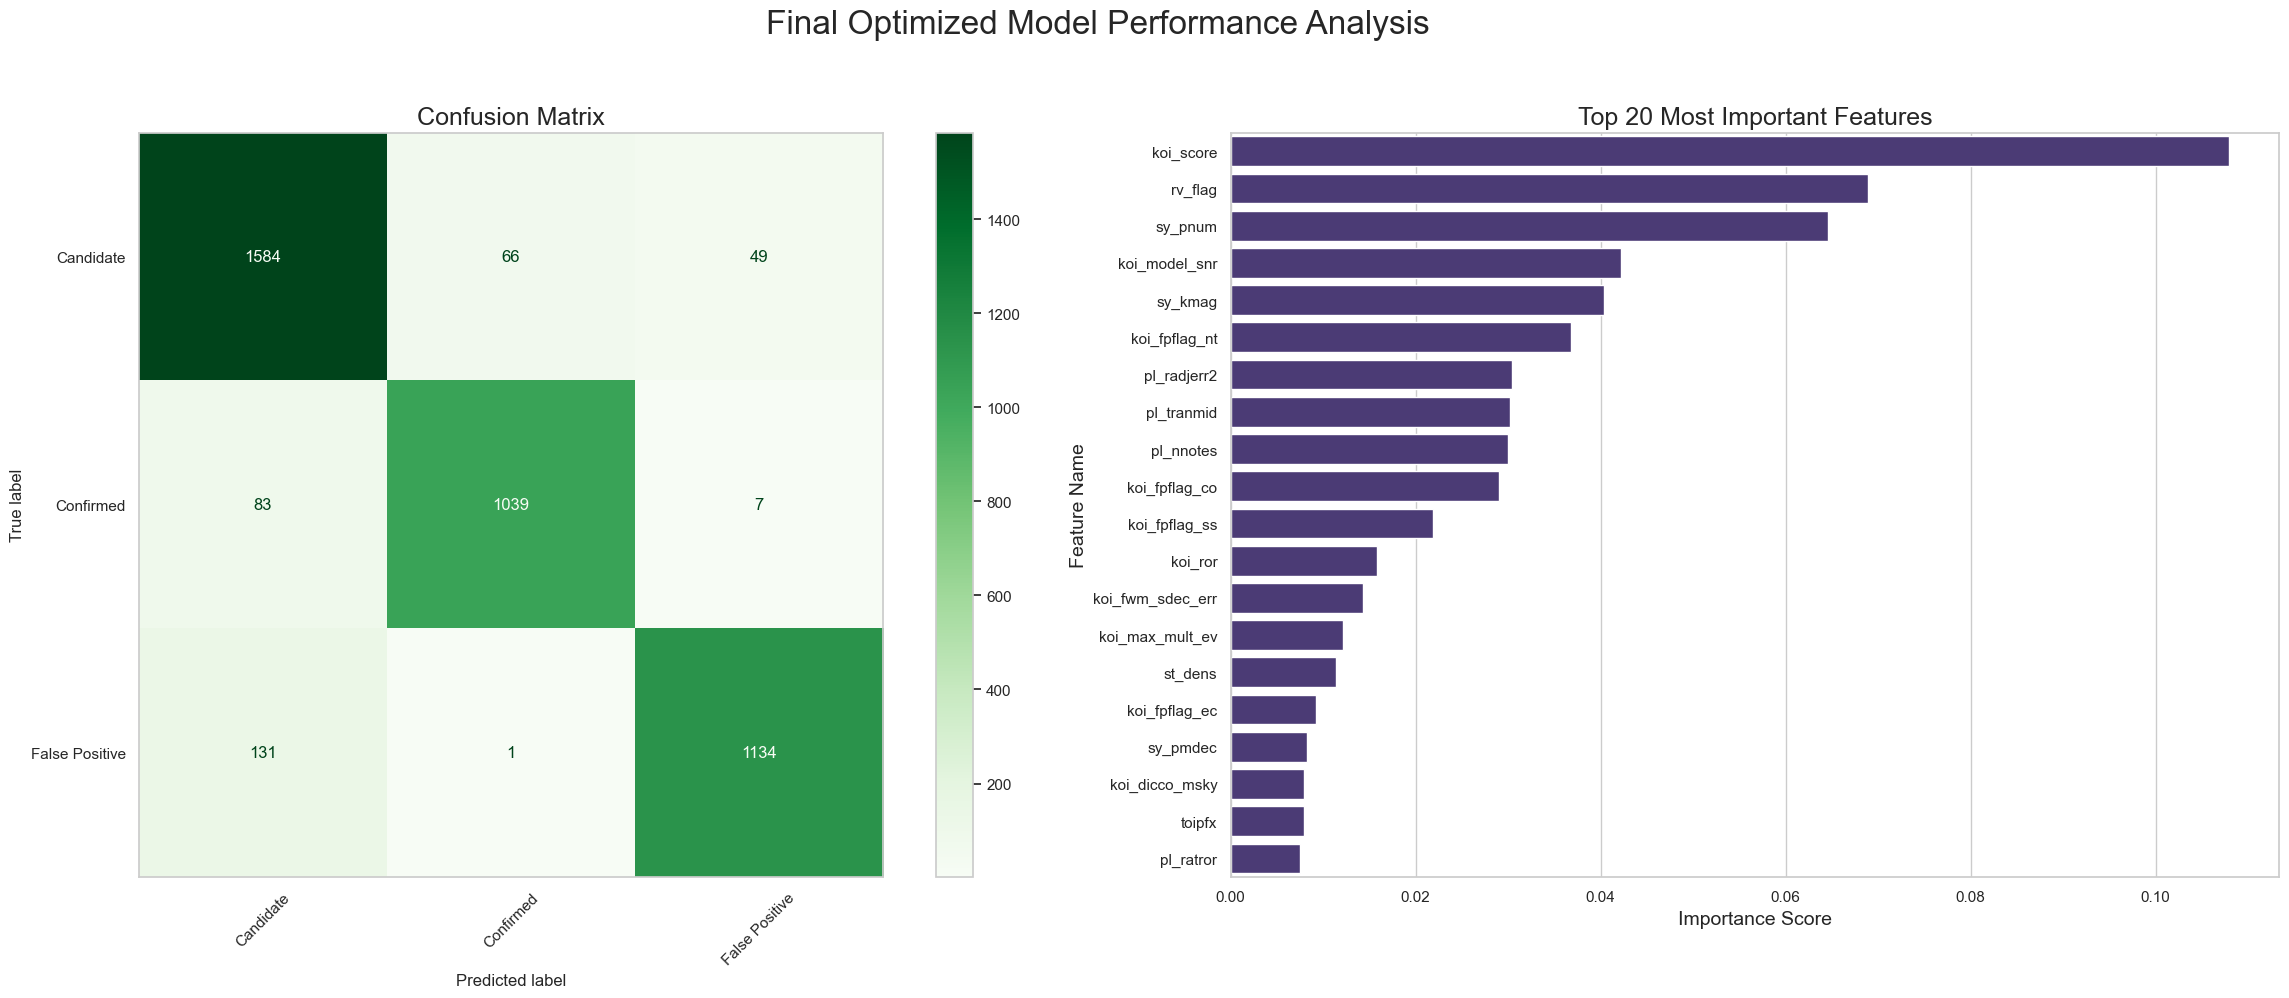

In [8]:
# --- CELL 8: Final Evaluation of the Optimized Model (CORRECTED) ---

from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

print("Evaluating the final optimized model on the test set...")
y_pred_best_xgb = best_model_xgb.predict(X_test_processed)

print(f"\nFinal Optimized XGBoost Model Accuracy: {accuracy_score(y_test_processed, y_pred_best_xgb):.2%}")
print("\nFinal Detailed Classification Report:")
print(classification_report(y_test_processed, y_pred_best_xgb, target_names=label_encoder.classes_))

# --- Visualization ---
fig, axes = plt.subplots(1, 2, figsize=(24, 10))
fig.suptitle('Final Optimized Model Performance Analysis', fontsize=24)

# --- Plot 1: Confusion Matrix ---
axes[0].grid(False)
ConfusionMatrixDisplay.from_predictions(y_test_processed, y_pred_best_xgb,
                                        display_labels=label_encoder.classes_,
                                        cmap=plt.cm.Greens,
                                        ax=axes[0],
                                        xticks_rotation=45)
axes[0].set_title('Confusion Matrix', fontsize=18)

# --- Plot 2: Feature Importance (ROBUST METHOD) ---
importances = best_model_xgb.feature_importances_

# CORREÇÃO: A fonte mais confiável para os nomes das features após a transformação
# é o próprio objeto que foi ajustado nos dados originais. O 'imputer' é uma ótima escolha.
# O 'imputer' tem um atributo '.feature_names_in_' que armazena os nomes das colunas que ele viu durante o .fit()
try:
    feature_names = imputer.get_feature_names_out()
except AttributeError:
    # Fallback para versões mais antigas do scikit-learn
    feature_names = X_train.columns

# Garante que os comprimentos correspondem
if len(feature_names) == len(importances):
    importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
    importance_df = importance_df.sort_values('importance', ascending=False).head(20)

    sns.barplot(x='importance', y='feature', data=importance_df, ax=axes[1])
    axes[1].set_title('Top 20 Most Important Features', fontsize=18)
    axes[1].set_xlabel('Importance Score', fontsize=14)
    axes[1].set_ylabel('Feature Name', fontsize=14)
else:
    axes[1].text(0.5, 0.5, f'Error: Mismatch in feature lengths.\nFeatures: {len(feature_names)}, Importances: {len(importances)}',
                 ha='center', va='center', fontsize=12, color='red')
    axes[1].set_title('Could not plot Feature Importance', fontsize=18)


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## 8. Final Step: Serializing and Saving the AI Artifacts

The final step in our notebook workflow is to **serialize** and save all the components of our AI system. Serialization is the process of converting our trained model and preprocessing tools into files that can be stored on disk. This makes our AI **portable and reusable**, allowing us to load it into any other application (like our Streamlit web app) without needing to retrain it from scratch.

We will save five critical **artifacts** to the `artifacts/` directory:
1.  **The Optimized XGBoost Model:** The trained "brain" of our AI.
2.  **The Imputer:** The tool fitted to handle missing values.
3.  **The Scaler:** The tool fitted to normalize feature scales.
4.  **The Label Encoder:** The tool that holds the mapping between class names and numbers.
5.  **The Feature Column List:** A list of the exact feature names in the correct order, crucial for ensuring prediction data is structured correctly.

By saving these artifacts, we are packaging our entire AI pipeline, turning our research into a deployable product.

In [9]:
# --- CELL 9: Serialize and Save Final AI Artifacts ---

import joblib
import os

# Define the directory where all final model assets will be stored.
artifacts_dir = 'artifacts'
# Create the directory if it doesn't already exist.
os.makedirs(artifacts_dir, exist_ok=True)

# --- 1. Serialize and Save All Components ---
# The dictionary below defines the object to save and its corresponding filename.
artifacts_to_save = {
    'exoplanet_xgboost_best_model.pkl': best_model_xgb,  # The champion model
    'super_scaler.pkl': scaler,                         # The fitted scaler
    'super_label_encoder.pkl': label_encoder,           # The fitted label encoder
    'super_imputer.pkl': imputer,                       # The fitted imputer
    'X_columns.pkl': list(X.columns)                    # The list of feature names
}

for filename, model_object in artifacts_to_save.items():
    joblib.dump(model_object, os.path.join(artifacts_dir, filename))

print(f"All AI artifacts have been successfully saved to the '{artifacts_dir}/' folder.")


# --- 2. Verification Step ---
# List the contents of the directory to provide a final visual confirmation.
print("\n" + "="*60)
print(f"Verification: Contents of the '{artifacts_dir}/' folder:")
try:
    saved_files = sorted(os.listdir(artifacts_dir)) # Sort for consistent order
    for file_name in saved_files:
        file_path = os.path.join(artifacts_dir, file_name)
        file_size = os.path.getsize(file_path) / 1024 # Get size in KB
        print(f"  - {file_name:<35} ({file_size:.2f} KB)")
except FileNotFoundError:
    print(f"--> ERROR: Could not find the '{artifacts_dir}/' directory to verify its contents.")
print("="*60)

All AI artifacts have been successfully saved to the 'artifacts/' folder.

Verification: Contents of the 'artifacts/' folder:
  - X_columns.pkl                       (5.86 KB)
  - exoplanet_super_model.pkl           (25361.34 KB)
  - exoplanet_xgboost_best_model.pkl    (1201.33 KB)
  - super_imputer.pkl                   (9.87 KB)
  - super_label_encoder.pkl             (0.50 KB)
  - super_scaler.pkl                    (9.70 KB)
